# Entendimiento de datos

No hay diccionario de los datos.
<br>La columna textos son opiniones que representan la voz de los habitantes locales para identificar las problemáticas de su entorno en términos de los ODS 1, 3 y 4, relacionados con “Fin de la pobreza”, “Salud y bienestar” y “Educación de calidad”. Se asume que estan en formato string ya que son textos
<br>Por otro lado, la comuna labels, es el numero de ODS mas relevante que se habla en la opinion (1,3,4). Aunque no se dice explícitamente se puede asumir que en caso de que el texto no haga ningún comentario referente a los ODS, tendría un valor de 0 en label, ya que no esta en términos de ninguno de los objetivos de desarollo. Se asume que estan en formato int, ya que es solo un número.

# Analsis y calidad de datos

In [ ]:
# Librerias generales
# Pandas
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Número máximo de filas a mostar
# Ranom seed
import numpy as np
np.random.seed(3301)
import re
import nltk

# Seaborn
import seaborn as sns
from collections import defaultdict

# Matplolib
%matplotlib inline
import matplotlib.pyplot as plt

#sklearn
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
db_location = '/content/drive/MyDrive/Datos_proyecto.xlsx'
# Cargar los datos
df_texto=pd.read_excel(db_location, sheet_name='Sheet1')
# Dimensiones de los datos
df_texto.shape

Mounted at /content/drive


(2424, 2)

In [ ]:
# Ver los datos
display(df_texto.sample(5))

,textos,labels
2372,"Durante este período, el gasto público en educ...",4
1433,"Recientemente, se modificó la regulación de la...",3
669,"El científico francés del siglo XIX, Claude Be...",4
2408,"Por ejemplo, el seguro de salud obligatorio co...",3
2238,Deben aplicarse políticas de educación y forma...,4


In [ ]:
df_texto.dtypes

,0
textos,object
labels,int64


Se debe trasformar la columna textos a string, para que tenga el tipo de dato correcto según lo explicado en entendimeinto de datos.

Completitud

In [ ]:
df_texto.isnull().sum()

,0
textos,0
labels,0


In [ ]:
# Proporción de nulos
(df_texto.isnull().sum() / len(df_texto)).sort_values(ascending=False)

,0
textos,0.0
labels,0.0


In [ ]:
# Rango de cada variable numérica
df_texto.describe(percentiles=[.05,.25,.5,.75,.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
labels,2424.0,3.006188,1.121012,1.0,1.0,3.0,3.0,4.0,4.0,4.0


In [ ]:
missing_percent = df_texto.isna().mean() * 100

# Filtrar solo columnas con valores faltantes
missing_cols = missing_percent[missing_percent > 0].sort_values(ascending=False)

print(missing_cols)

Series([], dtype: float64)


Los datos sí estan completos, ya que como se puede ver no hay valores faltantes.

Unicidad

In [ ]:
# Revisar duplicados totales
duplicados = df_texto.duplicated().sum()
duplicados

np.int64(0)

In [ ]:
# Revisar duplicador paricales
cols_to_compare = ["textos"]

duplicated_partials = df_texto[df_texto.duplicated(subset=cols_to_compare, keep=False)]
duplicated_partials = duplicated_partials.sort_values(by=cols_to_compare)
duplicated_partials

,textos,labels


Después de revisar los totales y parciales (mismo texto diferente label), no hay ninguno por lo que los datos proporcionados ya habían sido limpiados o no se tienen duplicados desde un inicio.

Consistencia

In [ ]:
# Distribución de labels
df_texto['labels'].value_counts().sort_index()

,count
labels,
1,505
3,894
4,1025


Al sumar los totales 505+894+1025=2424. Por lo que sí es consistente con el total.

Tambien se ve que no hay valores aparte de 1,3 y 4

In [ ]:
# Verificar si hay textos muy cortos o vacio que evitaron el analisis de NaN
df_texto['longitud_texto'] = df_texto['textos'].str.len()
textos_cortos = (df_texto['longitud_texto'] < 10).sum()
textos_cortos

np.int64(0)

In [ ]:
# 1. Textos que contienen números
textos_con_numeros = df_texto['textos'].str.contains(r'\d', na=False).sum()
print(f"Textos que contienen números: {textos_con_numeros}")
print(f"Porcentaje: {(textos_con_numeros / len(df_texto)) * 100:.2f}%")

# 2. Textos que contienen mayúsculas
textos_con_mayusculas = df_texto['textos'].str.contains(r'[A-Z]', na=False).sum()
print(f"\nTextos que contienen mayúsculas: {textos_con_mayusculas}")
print(f"Porcentaje: {(textos_con_mayusculas / len(df_texto)) * 100:.2f}%")

# 3. Textos que contienen símbolos
textos_con_simbolos = df_texto['textos'].str.contains(r'[^\w\s]', na=False).sum()
print(f"\nTextos que contienen símbolos: {textos_con_simbolos}")
print(f"Porcentaje: {(textos_con_simbolos / len(df_texto)) * 100:.2f}%")


Textos que contienen números: 1570
Porcentaje: 64.77%

Textos que contienen mayúsculas: 2424
Porcentaje: 100.00%

Textos que contienen símbolos: 2424
Porcentaje: 100.00%


Como se puede ver los datos sí son consistentes, los labels solo tienen datos válidos (1,3,4) y no se necesitó el 0 mencionado en el entendimiento. Los textos no tienen filas llenas de espacios y muy cortos que puedan afectar el análisis. El único detalle a tener en cuenta es las mayúsculas y minúsculas, las cuales poden generar problemas al tokenizar, por lo que se decidió convertir todo a minúsculas para evitar estos duplicados en los tokens.

Validez

In [ ]:
# Porcentaje de distribución
(df_texto['labels'].value_counts(normalize=True) * 100).sort_index()

,proportion
labels,
1,20.833333
3,36.881188
4,42.285479


Al sumar los porcentajes 20.833333+36.881188+42.258547=nos da el 100% de las apariciones por lo que sí es valido.

In [ ]:
# Pasar la columna texto de a string
df_texto["textos"] = df_texto["textos"].astype("string")
df_texto.dtypes

,0
textos,string[python]
labels,int64
longitud_texto,int64


Convertimos los textos a string para que tenga más sentido, cosa se que perdió al importar los datos por pandas.

Por último como se mencionó anteriormente se convierten todos los textos a solo minúsculas para evitar tokes repetidos.

In [ ]:
# Mostrar algunos ejemplos antes de la conversión
print("\nEjemplos antes de conversión:")
for i in range(3):
    print(f"{i+1}. {df_texto['textos'].iloc[i][:50]}...")


Ejemplos antes de conversión:
1. "Aprendizaje" y "educación" se consideran sinónimo...
2. Para los niños más pequeños (bebés y niños pequeño...
3. Además, la formación de especialistas en medicina ...


In [ ]:
df_texto['textos'] = df_texto['textos'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [ ]:
# Mostrar algunos ejemplos despues de la conversión
print("\nEjemplos antes de conversión:")
for i in range(3):
    print(f"{i+1}. {df_texto['textos'].iloc[i][:50]}...")


Ejemplos antes de conversión:
1. "aprendizaje" y "educación" se consideran sinónimo...
2. para los niños más pequeños (bebés y niños pequeño...
3. además, la formación de especialistas en medicina ...


#Modelado

### Descripción de los algoritmos utilizados

Para la construcción de los modelos de clasificación de opiniones ciudadanas hacia los Objetivos de Desarrollo Sostenible (ODS 1, 3 y 4), se implementaron tres algoritmos de aprendizaje supervisado ampliamente utilizados en problemas de procesamiento de lenguaje natural. Cada uno presenta diferentes enfoques, ventajas y limitaciones, lo que permite realizar una comparación balanceada y seleccionar el modelo más adecuado según las métricas de desempeño obtenidas.

1. Naive Bayes Multinomial (MNB).
Este algoritmo parte del supuesto de independencia condicional entre las palabras del texto, lo que lo convierte en un modelo probabilístico sencillo y eficiente para tareas de clasificación de documentos. La variante multinomial es particularmente adecuada para variables discretas como las frecuencias de términos, representadas mediante esquemas de bolsa de palabras o TF-IDF. Sus principales ventajas son la rapidez de entrenamiento, la facilidad de interpretación de los términos más relevantes por clase y su robustez frente a datos de alta dimensionalidad. Sin embargo, al asumir independencia entre las características, puede perder precisión en contextos donde la correlación entre palabras es importante.

2. Regresión Logística (One-vs-Rest).
Se trata de un modelo discriminativo lineal que estima la probabilidad de pertenencia de una instancia a una clase mediante la función sigmoide. Para problemas multiclase, se implementa en un esquema One-vs-Rest, donde se entrena un clasificador binario por cada categoría y se selecciona la de mayor probabilidad. Entre sus fortalezas destaca la interpretabilidad, ya que los coeficientes del modelo permiten identificar qué términos influyen positiva o negativamente en la predicción de cada ODS. Además, admite regularización (L1/L2) y manejo de desbalance a través de class weights, lo que mejora su capacidad de generalización. Su limitación principal radica en que modela fronteras lineales, lo que puede no capturar patrones complejos en el lenguaje.

3. Máquinas de Vectores de Soporte Lineales (LinearSVC).
Este algoritmo busca maximizar el margen entre las clases en un espacio de alta dimensionalidad. En el caso lineal, resulta muy efectivo para datos de texto representados con TF-IDF, ya que dichos vectores suelen ser dispersos y de gran tamaño. LinearSVC es reconocido como uno de los clasificadores más robustos para problemas de categorización de documentos, logrando un buen balance entre exactitud y capacidad de generalización. Su ventaja es la capacidad de manejar eficientemente grandes volúmenes de características y generar modelos con mayor poder discriminativo que la regresión logística en escenarios ruidosos. La desventaja es que, a diferencia de la regresión logística, no produce probabilidades calibradas de manera directa, lo que puede dificultar la interpretación en algunos casos.

Importaciones y utilidades:

In [ ]:
import re, numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import Bunch

RANDOM_STATE = 42

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)               # urls
    s = re.sub(r"[@#]\w+|\d+|[_/\\]", " ", s)             # menciones, hashtags, números
    s = re.sub(r"[^\wáéíóúñü\s]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def detect_label_column(df: pd.DataFrame) -> str:
    candidates = ["label","etiqueta","ods","ODS","objetivo","target","y","clase","categoria"]
    # si la columna es categórica con pocas clases (2-10) es buena candidata
    scored = []
    for c in df.columns:
        if c in candidates:
            scored.append((c, 0))
        # heurística por número de clases
        nunique = df[c].nunique(dropna=True)
        if 2 <= nunique <= 10 and df[c].dtype != float:
            scored.append((c, 1))
    if not scored:
        raise ValueError("No pude detectar la columna objetivo. Renombra tu columna de etiqueta a 'ods' o 'etiqueta'.")
    # prioriza candidatos explícitos
    scored = sorted(scored, key=lambda x: x[1])
    return scored[0][0]

def summarize_results(name, gs, X_test, y_test):
    y_pred = gs.predict(X_test)
    rep = classification_report(y_test, y_pred, digits=4, output_dict=True, zero_division=0)
    f1m = rep["macro avg"]["f1-score"]
    print(f"\n=== {name} ===")
    print("Mejores params (CV):", gs.best_params_)
    print("Mejor F1-macro (CV):", round(gs.best_score_, 4))
    print("\nReporte en TEST:")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    print("Matriz de confusión (TEST):")
    print(confusion_matrix(y_test, y_pred))
    return Bunch(name=name, gridsearch_=gs, y_pred=y_pred, f1_macro_cv=gs.best_score_, f1_macro_test=f1m)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, title="Matriz de confusión"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


Cargar y preparar el dataset de entrenamiento

In [ ]:
# Asegurar tipos y limpieza básica
df_texto = df_texto.copy()
if "textos" not in df_texto.columns:
    raise ValueError("No encuentro la columna 'textos' en df_texto.")

df_texto["textos"] = df_texto["textos"].astype(str).map(clean_text)

# Detectar columna objetivo automáticamente
label_col = detect_label_column(df_texto)
print("Columna objetivo detectada:", label_col)

# Filtrar filas vacías / nulas
df_texto = df_texto[(df_texto["textos"].str.len() > 0) & (df_texto[label_col].notna())].copy()

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    df_texto["textos"], df_texto[label_col],
    test_size=0.2, stratify=df_texto[label_col], random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


Columna objetivo detectada: labels


((1939,), (485,), (1939,), (485,))

Definir vectorizador y validación:

In [ ]:
# TF-IDF de palabras con bigramas; sublinear_tf mejora estabilidad
TFIDF_WORD = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,2),
    min_df=2,
    sublinear_tf=True
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


Entrenar los 3 modelos con GridSearchCV:


=== MNB + TFIDF(word) ===
Mejores params (CV): {'clf__alpha': 0.1, 'tfidf__min_df': 3}
Mejor F1-macro (CV): 0.9635

Reporte en TEST:
              precision    recall  f1-score   support

           1     0.9286    0.9010    0.9146       101
           3     0.9497    0.9497    0.9497       179
           4     0.9567    0.9707    0.9637       205

    accuracy                         0.9485       485
   macro avg     0.9450    0.9405    0.9427       485
weighted avg     0.9483    0.9485    0.9483       485

Matriz de confusión (TEST):
[[ 91   6   4]
 [  4 170   5]
 [  3   3 199]]


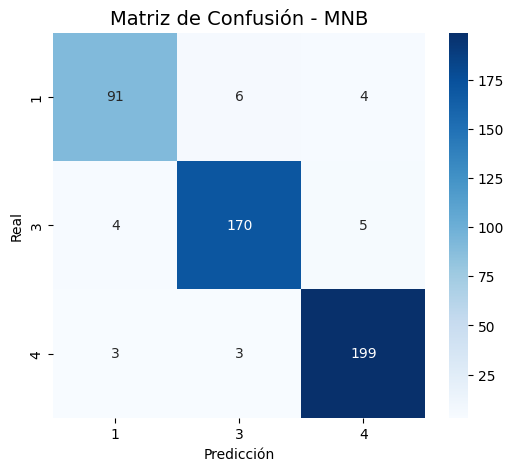


=== LogReg (OvR) + TFIDF(word) ===
Mejores params (CV): {'clf__C': 2, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__min_df': 5}
Mejor F1-macro (CV): 0.9739

Reporte en TEST:
              precision    recall  f1-score   support

           1     0.9697    0.9505    0.9600       101
           3     0.9661    0.9553    0.9607       179
           4     0.9617    0.9805    0.9710       205

    accuracy                         0.9649       485
   macro avg     0.9658    0.9621    0.9639       485
weighted avg     0.9650    0.9649    0.9649       485

Matriz de confusión (TEST):
[[ 96   4   1]
 [  1 171   7]
 [  2   2 201]]


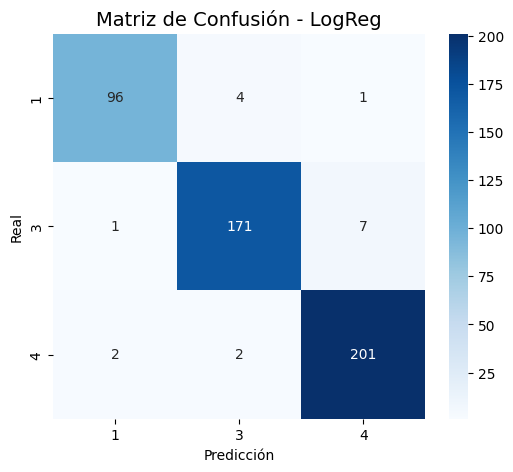


=== LinearSVC + TFIDF(word) ===
Mejores params (CV): {'clf__C': 0.5, 'clf__class_weight': 'balanced', 'tfidf__min_df': 3}
Mejor F1-macro (CV): 0.975

Reporte en TEST:
              precision    recall  f1-score   support

           1     0.9600    0.9505    0.9552       101
           3     0.9661    0.9553    0.9607       179
           4     0.9663    0.9805    0.9734       205

    accuracy                         0.9649       485
   macro avg     0.9641    0.9621    0.9631       485
weighted avg     0.9649    0.9649    0.9649       485

Matriz de confusión (TEST):
[[ 96   4   1]
 [  2 171   6]
 [  2   2 201]]


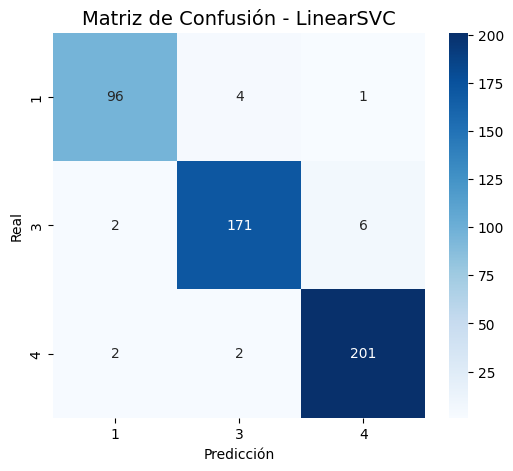

,modelo,F1_macro_CV,F1_macro_TEST
1,LogReg (OvR) + TFIDF(word),0.973906,0.963896
2,LinearSVC + TFIDF(word),0.975012,0.963088
0,MNB + TFIDF(word),0.963506,0.942658


In [ ]:
results = []

# --- MNB ---
mnb_pipe = Pipeline([("tfidf", TFIDF_WORD), ("clf", MultinomialNB())])
mnb_grid = {
    "tfidf__min_df": [2, 3, 5],
    "clf__alpha": [0.1, 0.3, 0.7, 1.0],
}
mnb_gs = GridSearchCV(
    mnb_pipe, mnb_grid, cv=cv, scoring="f1_macro",
    n_jobs=-1, verbose=0
)
mnb_gs.fit(X_train, y_train)
res_mnb = summarize_results("MNB + TFIDF(word)", mnb_gs, X_test, y_test)
results.append(res_mnb)

# --- Matriz de confusión para MNB ---
y_pred_mnb = mnb_gs.predict(X_test)
plot_confusion_matrix(
    y_test, y_pred_mnb,
    labels=mnb_gs.best_estimator_.named_steps['clf'].classes_,
    title="Matriz de Confusión - MNB"
)

# --- Regresión Logística (OvR) ---
lr_pipe = Pipeline([("tfidf", TFIDF_WORD), ("clf", LogisticRegression(max_iter=2000))])
lr_grid = {
    "tfidf__min_df": [2, 3, 5],
    "clf__C": [0.5, 1, 2, 4],
    "clf__class_weight": ["balanced"],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear", "lbfgs"],
}
lr_gs = GridSearchCV(
    lr_pipe, lr_grid, cv=cv, scoring="f1_macro",
    n_jobs=-1, verbose=0
)
lr_gs.fit(X_train, y_train)
res_lr = summarize_results("LogReg (OvR) + TFIDF(word)", lr_gs, X_test, y_test)
results.append(res_lr)

# --- Matriz de confusión para Regresión Logística ---
y_pred_lr = lr_gs.predict(X_test)
plot_confusion_matrix(
    y_test, y_pred_lr,
    labels=lr_gs.best_estimator_.named_steps['clf'].classes_,
    title="Matriz de Confusión - LogReg"
)

# --- LinearSVC ---
svm_pipe = Pipeline([("tfidf", TFIDF_WORD), ("clf", LinearSVC())])
svm_grid = {
    "tfidf__min_df": [2, 3, 5],
    "clf__C": [0.5, 1, 2, 4],
    "clf__class_weight": ["balanced"],
}
svm_gs = GridSearchCV(
    svm_pipe, svm_grid, cv=cv, scoring="f1_macro",
    n_jobs=-1, verbose=0
)
svm_gs.fit(X_train, y_train)
res_svm = summarize_results("LinearSVC + TFIDF(word)", svm_gs, X_test, y_test)
results.append(res_svm)

# --- Matriz de confusión para LinearSVC ---
y_pred_svm = svm_gs.predict(X_test)
plot_confusion_matrix(
    y_test, y_pred_svm,
    labels=svm_gs.best_estimator_.named_steps['clf'].classes_,
    title="Matriz de Confusión - LinearSVC"
)

# Resumen comparativo por F1-macro (TEST)
comparativo = pd.DataFrame([{
    "modelo": r.name,
    "F1_macro_CV": r.f1_macro_cv,
    "F1_macro_TEST": r.f1_macro_test
} for r in results]).sort_values("F1_macro_TEST", ascending=False)
comparativo


## Resultados
### Comparación de métricas clave

MNB + TFIDF:
- F1-macro en validación: 0.9635
- F1-macro en test: 0.9427
- Buen desempeño general, aunque con ligera caída de rendimiento al aplicarse en datos nuevos.

Regresión Logística + TFIDF:
- F1-macro en validación: 0.9739
- F1-macro en test: 0.9639
- Excelente balance entre precisión y recall en todas las clases, con mejor estabilidad entre validación y test.

LinearSVC + TFIDF:
- F1-macro en validación: 0.9750
- F1-macro en test: 0.9631
- Rendimiento muy similar a la Regresión Logística, con resultados consistentes y robustos en test.
### Análisis de métricas por clase (ODS)

ODS 1 (Fin de la pobreza):
Todos los modelos superan el 90% de F1-score, mostrando que las expresiones relacionadas con pobreza y desigualdad son detectadas con alta confiabilidad.

ODS 3 (Salud y bienestar):
Desempeño estable, con recall cercano al 95%, lo que significa que casi todas las opiniones sobre salud son identificadas correctamente.

ODS 4 (Educación de calidad):
Consistentemente el mejor desempeño, con F1 cercano a 97%, lo que indica que las problemáticas sobre educación son las más fáciles de clasificar.
### Interpretación para la organización

Métricas de calidad (F1, precisión y recall):
Estas métricas muestran que el modelo logra clasificar correctamente entre 94% y 96% de las opiniones, lo cual es un nivel muy alto para tareas de Procesamiento de Lenguaje Natural (PLN).

Impacto en los objetivos del negocio:
- Permite automatizar con alta confiabilidad la clasificación de la voz ciudadana según los ODS 1, 3 y 4.
- Facilita que el UNFPA y las entidades asociadas puedan priorizar políticas públicas basadas en evidencia de manera rápida y precisa.
- Reduce la dependencia de análisis manuales costosos y lentos, acelerando la retroalimentación hacia comunidades y gobiernos locales.
### Conclusión

Tanto Regresión Logística como LinearSVC se consolidan como los mejores modelos, con métricas muy similares y superiores al Naive Bayes.

La Regresión Logística + TFIDF se perfila como la opción más adecuada para despliegue inicial, dado su alto rendimiento, estabilidad y facilidad de interpretación.

Estos resultados son de confianza para la organización para usar el modelo en un entorno real, sabiendo que aportará decisiones informadas y alineadas con los ODS.

## Seleccionar el mejor modelo y explicar términos top

In [ ]:
# Elegir por F1_macro_TEST
best = max(results, key=lambda r: r.f1_macro_test)
best.name, best.f1_macro_cv, best.f1_macro_test

best_est = best.gridsearch_.best_estimator_
vec = best_est.named_steps["tfidf"]

# Importancia de términos para LR/SVM (coeficientes); para MNB usamos log prob.
def show_top_terms(best_estimator, topn=20):
    clf = best_estimator.named_steps["clf"]
    feature_names = np.array(vec.get_feature_names_out())
    if isinstance(clf, (LogisticRegression, LinearSVC)):
        # One-vs-Rest: coef_ por clase
        classes = clf.classes_
        coefs = clf.coef_
        for i, cls in enumerate(classes):
            idx = np.argsort(coefs[i])[-topn:]
            print(f"\nTop términos clase {cls}:")
            print(", ".join(feature_names[idx]))
    elif isinstance(clf, MultinomialNB):
        classes = clf.classes_
        log_prob = clf.feature_log_prob_
        for i, cls in enumerate(classes):
            idx = np.argsort(log_prob[i])[-topn:]
            print(f"\nTop términos clase {cls}:")
            print(", ".join(feature_names[idx]))
    else:
        print("Explicabilidad rápida no implementada para este clasificador.")

show_top_terms(best_est, topn=20)



Top términos clase 1:
de ingresos, infantil, transferencias, pobreza infantil, crecimiento, niños, empleo, los hogares, hogar, protección, privación, protección social, los pobres, hogares, ingresos, social, pobres, de pobreza, la pobreza, pobreza

Top términos clase 3:
enfermedad, servicios, médica, hospitales, alcohol, salud mental, atención primaria, tratamiento, mortalidad, los pacientes, mental, la atención, de atención, enfermedades, la salud, médicos, pacientes, atención, de salud, salud

Top términos clase 4:
los docentes, escolares, formación, de aprendizaje, profesores, los alumnos, habilidades, de educación, escolar, enseñanza, escuela, docentes, alumnos, las escuelas, aprendizaje, los estudiantes, la educación, escuelas, estudiantes, educación


## Análisis de términos y estrategias por ODS
### ODS 1 – Fin de la pobreza

Para el ODS 1 se identificaron los siguientes términos clave: ingresos, infantil, transferencias, pobreza infantil, crecimiento, empleo, hogares, protección social, privación, pobres.

Esto se puede interpretar en cómo las opiniones ciudadanas se centran en la falta de ingresos, la vulnerabilidad infantil y la necesidad de protección social. Esto refleja preocupación por seguridad económica básica y apoyo a hogares en situación de pobreza.

Teniendo esto en cuenta, algunas estrategias para la organización pueden ser:
- Diseñar e impulsar programas de transferencias condicionadas para familias con niños en edad escolar.
- Crear alianzas con entidades públicas y privadas para fomentar el empleo inclusivo.
- Implementar sistemas de monitoreo de pobreza infantil con indicadores claros.

Esta información permite priorizar recursos en programas sociales de impacto directo, alineados con la demanda ciudadana real y con alto potencial de legitimidad social.

### ODS 3 – Salud y bienestar
Para el ODS 3 se identificaron los siguientes términos clave: enfermedad, servicios médicos, hospitales, salud mental, atención primaria, tratamiento, mortalidad, pacientes, médicos, atención.

Esto se puede interpretar en los ciudadanos que exigen mejor cobertura y calidad en servicios de salud, con énfasis en atención primaria, salud mental y acceso a tratamientos.

Teniendo esto en cuenta, algunas estrategias para la organización pueden ser:
- Plantear programas de fortalecimiento en salud mental comunitaria, dada la alta frecuencia del término.
- Optimizar redes hospitalarias y de atención primaria para reducir mortalidad y mejorar tiempos de respuesta.
- Promover campañas de prevención frente al alcohol y enfermedades crónicas.

Los hallazgos permiten a la organización identificar brechas críticas en la cobertura sanitaria y anticipar políticas públicas más inclusivas, especialmente en salud mental, donde la percepción ciudadana es más fuerte.

### ODS 4 – Educación de calidad
Para el ODS 4 se identificaron los siguientes términos clave:docentes, escolares, aprendizaje, profesores, alumnos, enseñanza, escuela, habilidades, estudiantes, educación.

Esto se puede interpretar en cómo la ciudadanía relaciona directamente la calidad educativa con los docentes y su formación, además de la importancia de las habilidades escolares y la infraestructura educativa.

Teniendo esto en cuenta, algunas estrategias para la organización pueden ser:
- Impulsar programas de capacitación docente continua, enfocados en innovación pedagógica y competencias digitales.
- Invertir en infraestructura escolar moderna y accesible para estudiantes de bajos recursos.
- Desarrollar proyectos de acompañamiento escolar para reforzar habilidades básicas.

Este análisis ayuda a enfocar recursos en el factor docente y la formación de habilidades, que son los ejes señalados por la propia comunidad como determinantes para una educación de calidad.

Cargar Datos de prueba, predecir con el mejor modelo y guardar Excel:

In [ ]:
test_path = "/content/drive/MyDrive/Datos de prueba_proyecto.xlsx"

df_prueba = pd.read_excel(test_path, sheet_name=0)
if "Textos_espanol" not in df_prueba.columns:
    raise ValueError("En el archivo de prueba no existe la columna 'textos'. Renómbrala o ajusta el código.")

df_prueba = df_prueba.copy()
df_prueba["Textos_espanol"] = df_prueba["Textos_espanol"].astype(str).map(clean_text)

y_pred_prueba = best_est.predict(df_prueba["Textos_espanol"])
# Columna de salida: 'prediccion_ods'
df_prueba["prediccion_ods"] = y_pred_prueba

out_path = "/content/drive/MyDrive/Datos_prueba_etiquetado.xlsx"
df_prueba.to_excel(out_path, index=False, engine="openpyxl")
out_path


'/content/drive/MyDrive/Datos_prueba_etiquetado.xlsx'

In [ ]:
import joblib

model_dir = Path("/content/drive/MyDrive/modelos_proy1")
model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_est, model_dir / "mejor_modelo_tfidf.joblib")
(joblib.load(model_dir / "mejor_modelo_tfidf.joblib") is not None)


True

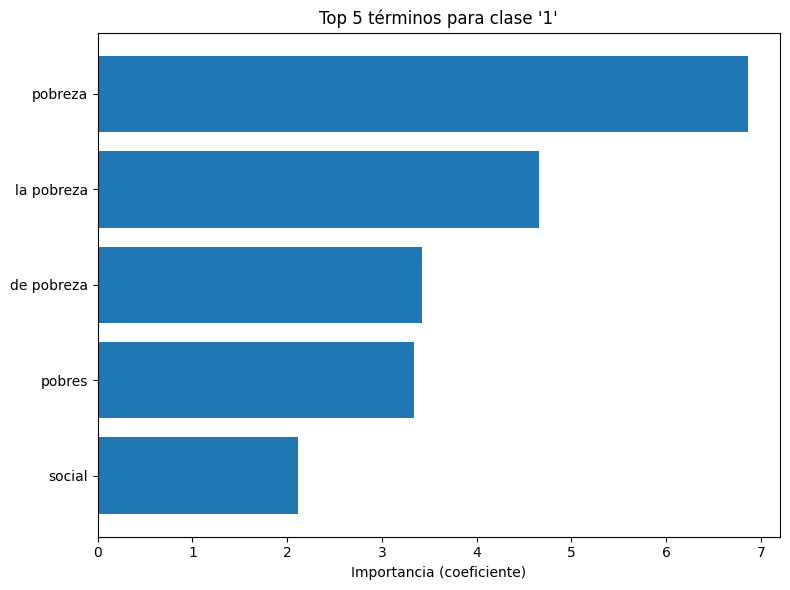

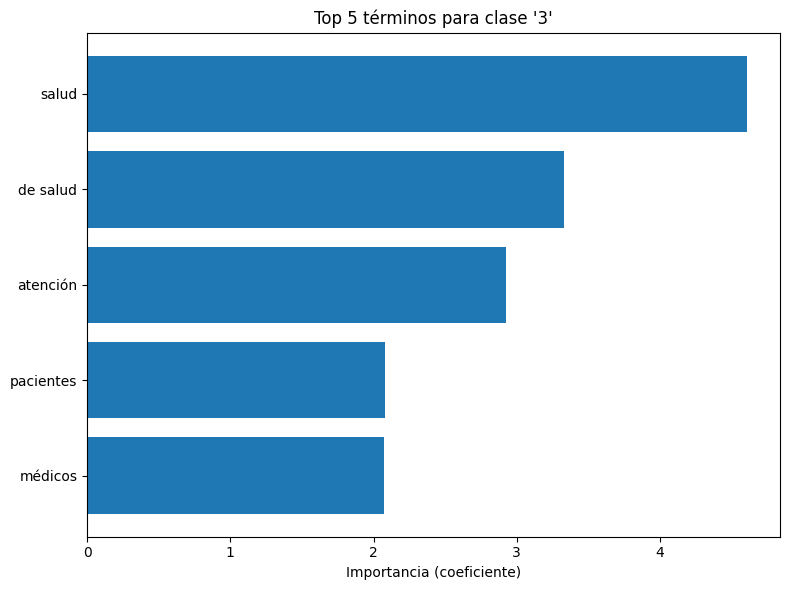

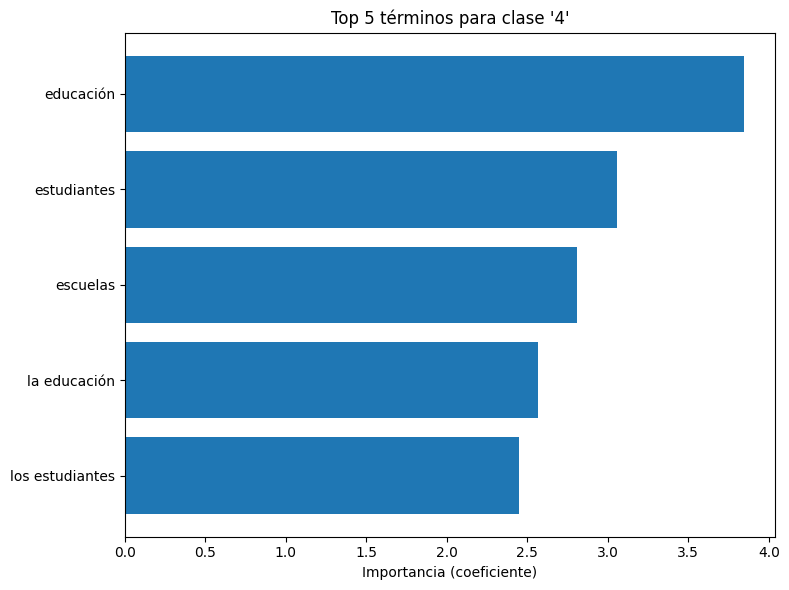

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_terms(best_estimator, topn=5):
    vec = best_estimator.named_steps["tfidf"]
    clf = best_estimator.named_steps["clf"]
    feature_names = np.array(vec.get_feature_names_out())

    if isinstance(clf, (LogisticRegression, LinearSVC)):
        # Tomamos la primera clase (puedes iterar si quieres todas)
        classes = clf.classes_
        for i, cls in enumerate(classes):
            coefs = clf.coef_[i]
            idx = np.argsort(coefs)[-topn:]  # top positivos
            plt.figure(figsize=(8, 6))
            plt.barh(range(topn), coefs[idx], align="center")
            plt.yticks(range(topn), feature_names[idx])
            plt.title(f"Top {topn} términos para clase '{cls}'")
            plt.xlabel("Importancia (coeficiente)")
            plt.tight_layout()
            plt.show()

    elif isinstance(clf, MultinomialNB):
        classes = clf.classes_
        for i, cls in enumerate(classes):
            log_prob = clf.feature_log_prob_[i]
            idx = np.argsort(log_prob)[-topn:]
            plt.figure(figsize=(8, 6))
            plt.barh(range(topn), log_prob[idx], align="center")
            plt.yticks(range(topn), feature_names[idx])
            plt.title(f"Top {topn} términos para clase '{cls}'")
            plt.xlabel("Importancia (log prob)")
            plt.tight_layout()
            plt.show()
    else:
        print("Explicabilidad rápida no implementada para este clasificador.")

# Llamar a la función
plot_top_terms(best_est, topn=5)


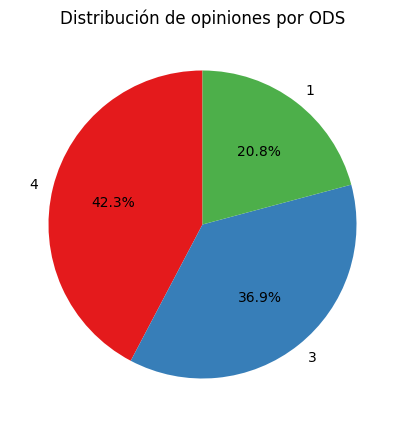

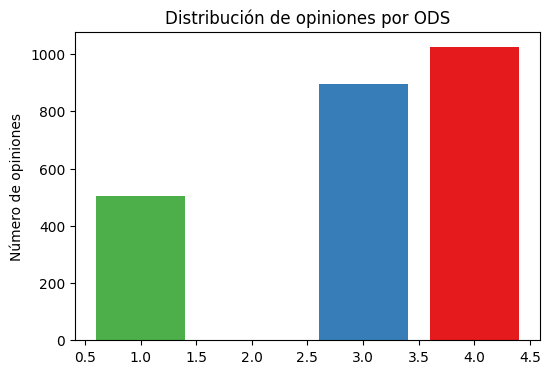

In [ ]:
# Conteo de opiniones por ODS
conteo = df_texto["labels"].value_counts()

# Gráfico de torta
plt.figure(figsize=(5, 5))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%',
        colors=["#e41a1c", "#377eb8", "#4daf4a"], startangle=90)
plt.title("Distribución de opiniones por ODS")
plt.show()

# Gráfico de barras (alternativo si prefieres más formal que torta)
plt.figure(figsize=(6, 4))
plt.bar(conteo.index, conteo.values, color=["#e41a1c", "#377eb8", "#4daf4a"])
plt.ylabel("Número de opiniones")
plt.title("Distribución de opiniones por ODS")
plt.show()


In [ ]:
# Tomar algunas muestras de opiniones y sus predicciones
ejemplos = df_texto.sample(5, random_state=42)[["textos", "labels"]]

print("Ejemplos de clasificación del modelo:\n")
for i, fila in ejemplos.iterrows():
    print(f"Texto: {fila['textos']}")
    print(f"ODS Real: {fila['labels']}")
    print("-" * 80)


Ejemplos de clasificación del modelo:

Texto: por lo general se entiende que los trastornos de leves a moderados no requieren tratamientos altamente especializados administrados por psiquiatras o en entornos hospitalarios en la gran mayoría de los casos en cambio en la mayoría de los países de la ocde los médicos de atención primaria asumen un papel de liderazgo en el tratamiento de trastornos leves a moderados ver tabla cuando la provisión a nivel de atención primaria para los trastornos leves a moderados está respaldada por una buena capacitación tanto durante la capacitación médica como como parte de la educación médica continua por el apoyo de profesionales especialistas en atención de la salud mental y redes de apoyo y por buenas opciones de derivación si un paciente necesita acceder a un nivel de atención más especializado puede ser una forma muy eficaz de brindar atención a un gran número de pacientes
ODS Real: 3
------------------------------------------------------------------

In [ ]:
from sklearn.metrics import f1_score, r2_score

def evaluar_modelo(nombre, gridsearch, X_test, y_test):
    y_pred = gridsearch.predict(X_test)

    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    f1_clases = f1_score(y_test, y_pred, average=None)

    r2 = r2_score(y_test, y_pred)

    return {
        "modelo": nombre,
        "F1_macro": f1_macro,
        "F1_micro": f1_micro,
        "F1_weighted": f1_weighted,
        "F1_por_clase": dict(zip(gridsearch.best_estimator_.named_steps["clf"].classes_, f1_clases)),
        "R2": r2
    }

# Evaluar los tres modelos
resumen_metricas = []
resumen_metricas.append(evaluar_modelo("MNB", mnb_gs, X_test, y_test))
resumen_metricas.append(evaluar_modelo("Logistic Regression", lr_gs, X_test, y_test))
resumen_metricas.append(evaluar_modelo("LinearSVC", svm_gs, X_test, y_test))

# Pasar a DataFrame para ver comparativo
df_metricas = pd.DataFrame([{
    "Modelo": r["modelo"],
    "F1_macro": r["F1_macro"],
    "F1_micro": r["F1_micro"],
    "F1_weighted": r["F1_weighted"],
    "R2": r["R2"]
} for r in resumen_metricas])

display(df_metricas)

# Si quieres también ver F1 por clase:
for r in resumen_metricas:
    print(f"\nModelo: {r['modelo']}")
    for cls, score in r["F1_por_clase"].items():
        print(f"  Clase {cls}: F1 = {score:.3f}")


,Modelo,F1_macro,F1_micro,F1_weighted,R2
0,MNB,0.942658,0.948454,0.948302,0.817728
1,Logistic Regression,0.963896,0.964948,0.964904,0.908043
2,LinearSVC,0.963088,0.964948,0.964904,0.903117



Modelo: MNB
  Clase 1: F1 = 0.915
  Clase 3: F1 = 0.950
  Clase 4: F1 = 0.964

Modelo: Logistic Regression
  Clase 1: F1 = 0.960
  Clase 3: F1 = 0.961
  Clase 4: F1 = 0.971

Modelo: LinearSVC
  Clase 1: F1 = 0.955
  Clase 3: F1 = 0.961
  Clase 4: F1 = 0.973
